# Parse and MNIST-IZE Kannada Digits from handwritten grid scans:

This notebook goes through the process of generating a handwritten test dataset for Kannada digits. The first step is to construct a grid of handwritten digits using a quad ruled notepad as shown below. Afterwards, the images are generated by:

*   Slicing/extracting individual digit cells
*   MNIST-izing digit cells (eg. resizing digit images to 28x28, denoising by thresholding, and centering using center of mass)

In [0]:
# Imports
import cv2
from matplotlib import pyplot as plt
from scipy import ndimage
import numpy as np
from PIL import Image
from tqdm import tqdm_notebook
import operator
import warnings
warnings.filterwarnings('ignore')

## Helper functions -1:  Processing the scans: Alignement, cropping and slicing

This scan slignment code is based on this nifty sudoku grid extractor found here:
https://gist.github.com/mineshpatel1/209038c64c19d5e78e0a878320797631#file-sudoku_cv-py

In [0]:

def plot_many_images(images, titles, rows=1, columns=2):
	"""Plots each image in a given list as a grid structure. using Matplotlib."""
	for i, image in enumerate(images):
		plt.subplot(rows, columns, i+1)
		plt.imshow(image, 'gray')
		plt.title(titles[i])
		plt.xticks([]), plt.yticks([])  # Hide tick marks
	plt.show()


def show_image(img):
	"""Shows an image until any key is pressed"""
	cv2_imshow(img)  # Display the image
	cv2.waitKey(0)  # Wait for any key to be pressed (with the image window active)
	cv2.destroyAllWindows()  # Close all windows


def show_digits(digits, colour=255):
	"""Shows list of 81 extracted digits in a grid format"""
	rows = []
	with_border = [cv2.copyMakeBorder(img.copy(), 1, 1, 1, 1, cv2.BORDER_CONSTANT, None, colour) for img in digits]
	for i in range(9):
		row = np.concatenate(with_border[i * 9:((i + 1) * 9)], axis=1)
		rows.append(row)
	show_image(np.concatenate(rows))


def convert_when_colour(colour, img):
	"""Dynamically converts an image to colour if the input colour is a tuple and the image is grayscale."""
	if len(colour) == 3:
		if len(img.shape) == 2:
			img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
		elif img.shape[2] == 1:
			img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
	return img


def display_points(in_img, points, radius=5, colour=(0, 0, 255)):
	"""Draws circular points on an image."""
	img = in_img.copy()

	# Dynamically change to a colour image if necessary
	if len(colour) == 3:
		if len(img.shape) == 2:
			img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
		elif img.shape[2] == 1:
			img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

	for point in points:
		img = cv2.circle(img, tuple(int(x) for x in point), radius, colour, -1)
	show_image(img)
	return img


def display_rects(in_img, rects, colour=(0, 0, 255)):
	"""Displays rectangles on the image."""
	img = convert_when_colour(colour, in_img.copy())
	for rect in rects:
		img = cv2.rectangle(img, tuple(int(x) for x in rect[0]), tuple(int(x) for x in rect[1]), colour)
	show_image(img)
	return img


def display_contours(in_img, contours, colour=(0, 0, 255), thickness=2):
	"""Displays contours on the image."""
	img = convert_when_colour(colour, in_img.copy())
	img = cv2.drawContours(img, contours, -1, colour, thickness)
	show_image(img)


def pre_process_image(img, skip_dilate=False):
	"""Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""

	# Gaussian blur with a kernal size (height, width) of 9.
	# Note that kernal sizes must be positive and odd and the kernel must be square.
	proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

	# Adaptive threshold using 11 nearest neighbour pixels
	proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

	# Invert colours, so gridlines have non-zero pixel values.
	# Necessary to dilate the image, otherwise will look like erosion instead.
	proc = cv2.bitwise_not(proc, proc)

	if not skip_dilate:
		# Dilate the image to increase the size of the grid lines.
		kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
		proc = cv2.dilate(proc, kernel)

	return proc


def find_corners_of_largest_polygon(img):
	"""Finds the 4 extreme corners of the largest contour in the image."""
	_, contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
	contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
	polygon = contours[0]  # Largest image

	# Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
	# Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

	# Bottom-right point has the largest (x + y) value
	# Top-left has point smallest (x + y) value
	# Bottom-left point has smallest (x - y) value
	# Top-right point has largest (x - y) value
	bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
	top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
	bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
	top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

	# Return an array of all 4 points using the indices
	# Each point is in its own array of one coordinate
	return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]


def distance_between(p1, p2):
	"""Returns the scalar distance between two points"""
	a = p2[0] - p1[0]
	b = p2[1] - p1[1]
	return np.sqrt((a ** 2) + (b ** 2))


def crop_and_warp(img, crop_rect):
	"""Crops and warps a rectangular section from an image into a square of similar size."""

	# Rectangle described by top left, top right, bottom right and bottom left points
	top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

	# Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
	src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

	# Get the longest side in the rectangle
	side = max([
		distance_between(bottom_right, top_right),
		distance_between(top_left, bottom_left),
		distance_between(bottom_right, bottom_left),
		distance_between(top_left, top_right)
	])

	# Describe a square with side of the calculated length, this is the new perspective we want to warp to
	dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

	# Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
	m = cv2.getPerspectiveTransform(src, dst)

	# Performs the transformation on the original image
	return cv2.warpPerspective(img, m, (int(side), int(side)))





def cut_from_rect(img, rect):
	"""Cuts a rectangle from an image using the top left and bottom right points."""
	return img[int(rect[0][1]):int(rect[1][1]), int(rect[0][0]):int(rect[1][0])]


def scale_and_centre(img, size, margin=0, background=0):
	"""Scales and centres an image onto a new background square."""
	h, w = img.shape[:2]

	def centre_pad(length):
		"""Handles centering for a given length that may be odd or even."""
		if length % 2 == 0:
			side1 = int((size - length) / 2)
			side2 = side1
		else:
			side1 = int((size - length) / 2)
			side2 = side1 + 1
		return side1, side2

	def scale(r, x):
		return int(r * x)

	if h > w:
		t_pad = int(margin / 2)
		b_pad = t_pad
		ratio = (size - margin) / h
		w, h = scale(ratio, w), scale(ratio, h)
		l_pad, r_pad = centre_pad(w)
	else:
		l_pad = int(margin / 2)
		r_pad = l_pad
		ratio = (size - margin) / w
		w, h = scale(ratio, w), scale(ratio, h)
		t_pad, b_pad = centre_pad(h)

	img = cv2.resize(img, (w, h))
	img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
	return cv2.resize(img, (size, size))


def find_largest_feature(inp_img, scan_tl=None, scan_br=None):
	"""
	Uses the fact the `floodFill` function returns a bounding box of the area it filled to find the biggest
	connected pixel structure in the image. Fills this structure in white, reducing the rest to black.
	"""
	img = inp_img.copy()  # Copy the image, leaving the original untouched
	height, width = img.shape[:2]

	max_area = 0
	seed_point = (None, None)

	if scan_tl is None:
		scan_tl = [0, 0]

	if scan_br is None:
		scan_br = [width, height]

	# Loop through the image
	for x in range(scan_tl[0], scan_br[0]):
		for y in range(scan_tl[1], scan_br[1]):
			# Only operate on light or white squares
			if img.item(y, x) == 255 and x < width and y < height:  # Note that .item() appears to take input as y, x
				area = cv2.floodFill(img, None, (x, y), 64)
				if area[0] > max_area:  # Gets the maximum bound area which should be the grid
					max_area = area[0]
					seed_point = (x, y)

	# Colour everything grey (compensates for features outside of our middle scanning range
	for x in range(width):
		for y in range(height):
			if img.item(y, x) == 255 and x < width and y < height:
				cv2.floodFill(img, None, (x, y), 64)

	mask = np.zeros((height + 2, width + 2), np.uint8)  # Mask that is 2 pixels bigger than the image

	# Highlight the main feature
	if all([p is not None for p in seed_point]):
		cv2.floodFill(img, mask, seed_point, 255)

	top, bottom, left, right = height, 0, width, 0

	for x in range(width):
		for y in range(height):
			if img.item(y, x) == 64:  # Hide anything that isn't the main feature
				cv2.floodFill(img, mask, (x, y), 0)

			# Find the bounding parameters
			if img.item(y, x) == 255:
				top = y if y < top else top
				bottom = y if y > bottom else bottom
				left = x if x < left else left
				right = x if x > right else right

	bbox = [[left, top], [right, bottom]]
	return img, np.array(bbox, dtype='float32'), seed_point


def extract_digit(img, rect, size):
	"""Extracts a digit (if one exists) from a Sudoku square."""

	digit = cut_from_rect(img, rect)  # Get the digit box from the whole square

	# Use fill feature finding to get the largest feature in middle of the box
	# Margin used to define an area in the middle we would expect to find a pixel belonging to the digit
	h, w = digit.shape[:2]
	margin = int(np.mean([h, w]) / 2.5)
	_, bbox, seed = find_largest_feature(digit, [margin, margin], [w - margin, h - margin])
	digit = cut_from_rect(digit, bbox)

	# Scale and pad the digit so that it fits a square of the digit size we're using for machine learning
	w = bbox[1][0] - bbox[0][0]
	h = bbox[1][1] - bbox[0][1]

	# Ignore any small bounding boxes
	if w > 0 and h > 0 and (w * h) > 100 and len(digit) > 0:
		return scale_and_centre(digit, size, 4)
	else:
		return np.zeros((size, size), np.uint8)


def get_digits(img, squares, size):
	"""Extracts digits from their cells and builds an array"""
	digits = []
	img = pre_process_image(img.copy(), skip_dilate=True)
	for square in squares:
		digits.append(extract_digit(img, square, size))
	return digits


def parse_grid(path,DIG_SIZE=28):
	original = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
	processed = pre_process_image(original)
	corners = find_corners_of_largest_polygon(processed)
	cropped = crop_and_warp(original, corners)
	squares = infer_grid(cropped)
	digits = get_digits(cropped, squares, DIG_SIZE)
	show_digits(digits)

## Helper functions -2:  MNIST-izing the alignement, cropped and sliced images


Both our input seed images (used in synthetic data generation for the training dataset) and handwritten digits (test dataset) will adhere to the standard MNIST format. This means a 28x28 size digit image will be centered in a 20x20 pixel box. We leveraged the code provided in this wonderful blogpost titled "Tensorflow, MNIST and your own handwritten digits" to help MNIST-ize our data (https://medium.com/@o.kroeger/tensorflow-mnist-and-your-own-handwritten-digits-4d1cd32bbab4). 

In [0]:
# Helper Functions to MNIST-ize data

def getBestShift(img):
    '''
    Returns the best shift in x and y directions
    Input: 
      img: np.array
    Output:
      sx: float
      sy: float

    '''
    # Calculate the center of mass coordinates for values in the image array
    cy, cx = ndimage.measurements.center_of_mass(img)
    rows, cols = img.shape 
  
    # Apply vertical and horizontal shift 
    sx = np.round(cols/2.0-cx).astype(int)
    sy = np.round(rows/2.0-cy).astype(int)
 
    return sx, sy

def shift(img, sx, sy):
    '''
    Returns shifted version of the input image
    Input: 
        img: np.array
        sx: float
        sy: float
    Output:
        img_new: np.array

    '''
    rows, cols = img.shape
    
    M = np.float32([[1, 0, sx], [0, 1, sy]]) # Transformation matrix to shift image
    shifted = cv2.warpAffine(img, M, (cols, rows)) 
  
    return shifted

def mnistize(img):
    '''
    Returns the MNIST-ized version of the input image
    Input: 
        img: np.array
    Output:
        img_new: np.array

    '''
    img = cv2.resize(255-img, (28, 28))
    
    # Apply Binary + Otsu thresholding on image
    # More info here: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html#otsus-binarization
    (thresh, img) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Create tight bounding box for digit
    while np.sum(img[0]) == 0:
        img = img[1:]

    while np.sum(img[:,0]) == 0:
        img = np.delete(img, 0, 1)

    while np.sum(img[-1]) == 0:
        img = img[:-1]

    while np.sum(img[:,-1]) == 0:
        img = np.delete(img, -1, 1)

    rows, cols = img.shape

    # Resize image to fit a 20x20 box
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
    img = cv2.resize(img, (cols, rows))

    # Pad rows/columns to form 28x28 image
    colsPadding = (int(np.ceil((28-cols)/2.0)), int(np.floor((28-cols)/2.0)))
    rowsPadding = (int(np.ceil((28-rows)/2.0)), int(np.floor((28-rows)/2.0)))
    img = np.lib.pad(img, (rowsPadding, colsPadding), 'constant')

    # Find and apply best shift 
    shiftx, shifty = getBestShift(img)
    img = shift(img, shiftx, shifty)

    return img

# Load the data: Here comes the fun part!

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# 65 volunteers wrote $32 \times 40=1280$ digits each on a sheet of white paper with pre-printed grids. 
Let's load the files and ascertain what the file sizes are ..

In [5]:
import os
project_dir=('/gdrive/My Drive/Colab Notebooks/Kannada_MNIST')
scan_dir=os.path.join(project_dir,'data/input_scans/scans_Main')
os.chdir(project_dir)
scanned_files=os.listdir(scan_dir)
scanned_files=sorted(sorted(scanned_files),key=len)
scanned_files[0:5]

['KM--C60853790_Page_01.png',
 'KM--C60853790_Page_02.png',
 'KM--C60853790_Page_03.png',
 'KM--C60853790_Page_04.png',
 'KM--C60853790_Page_05.png']

The data parsing process is demonstrated below for handwritten Kannada digits (40x32 = 1280 digits), which will make up the test dataset. However this approach for creating and extracting the digits can be applied to other scripts as well. To create the data sheet, the volunteer writes each digit across the row 32 times (32 is the number of cells that make up each row in the quad ruled notepad), completes this for digits 0-9, and repeats this process 4 times for a total of 40 rows and 1280 handwritten digitis. This sheet is then scanned and saved as a .png file. 

Text(0.5, 0, 'Scanned image index')

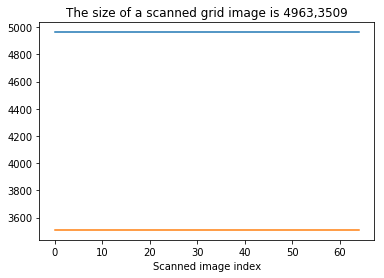

In [6]:
n_scans=len(scanned_files)
grid_sizes=np.zeros((n_scans,2),dtype=int)
for i,file_id in enumerate(scanned_files):
  im_grid=Image.open(os.path.join(scan_dir,file_id)).convert('L')
  grid_sizes[i,:]=im_grid.size

plt.plot(grid_sizes[:,0])
plt.plot(grid_sizes[:,1])
plt.title(f'The size of a scanned grid image is {grid_sizes[0,0]},{grid_sizes[0,1]}')
plt.xlabel('Scanned image index')

# Let's test this out for one example!

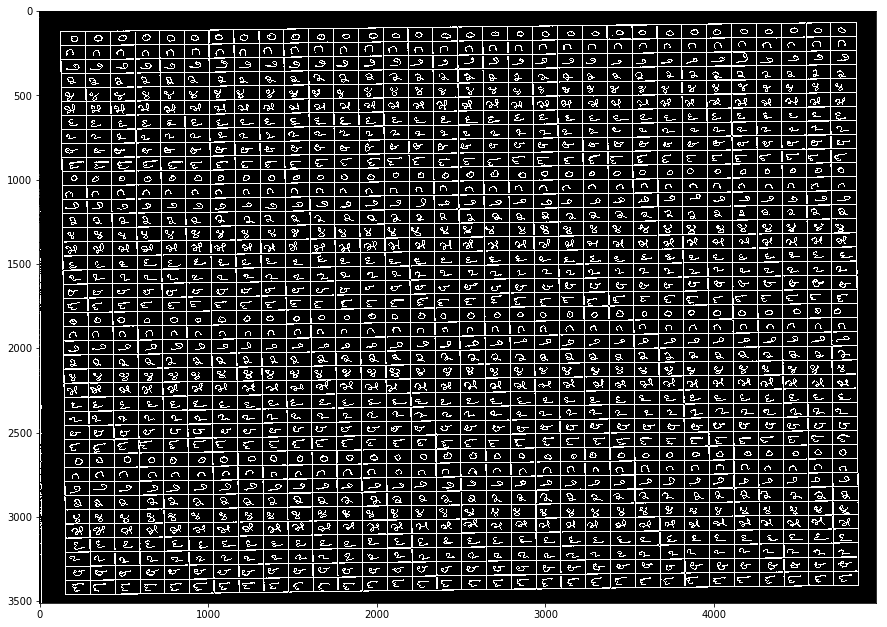

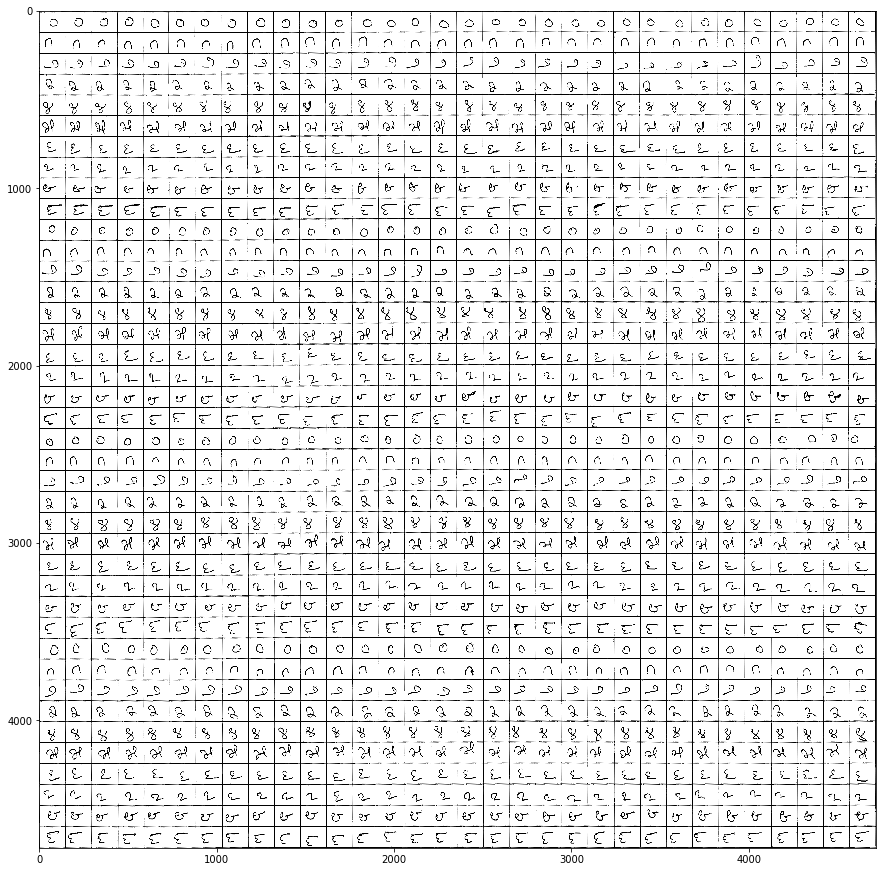

In [7]:
original = cv2.imread(os.path.join(scan_dir,scanned_files[0]), cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(original)
plt.figure(figsize=(15,18))
plt.imshow(processed,cmap='gray')
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(original, corners)
plt.figure(figsize=(15,18))
plt.imshow(cropped,cmap='gray')


## Now, let's extract the digit for random index pairs 

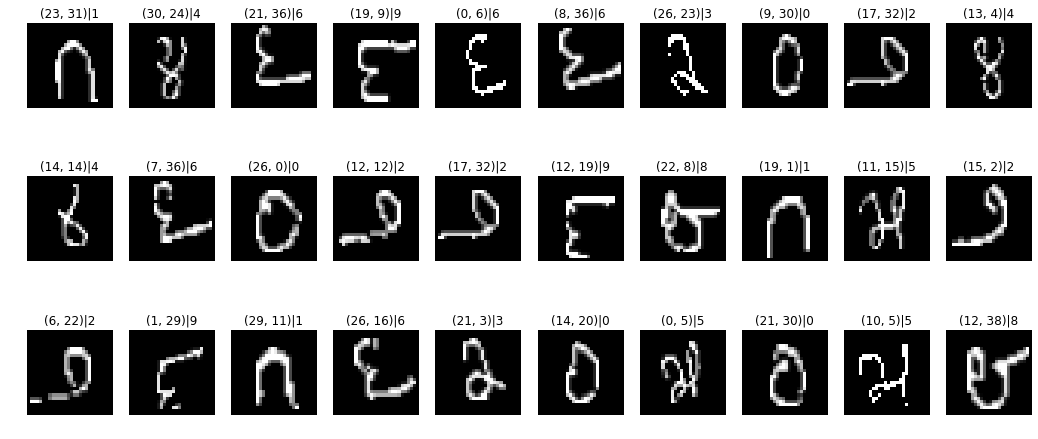

In [8]:
im_grid_cropped=Image.fromarray(cropped)
width=cropped.shape[0]/32
height=cropped.shape[1]/40
##
border_offset=18
x = np.arange(0, 32*width, width)
y = np.arange(0, 40*height, height)
xv, yv = np.meshgrid(x, y, indexing='xy') # Construct grid of x,y values
plt.figure(figsize=(border_offset,8))
# Let's take 10 random slices
for trial in range(30):
    i = np.random.randint(0, 31)
    j = np.random.randint(0, 39)
    x,y = (xv[j, i], yv[j, i])
    cropped_ = im_grid_cropped.crop((x+border_offset, y+border_offset, x+width-border_offset , y+height-border_offset)) # Crop the image 
    x_rand_image = mnistize(np.array(cropped_)) # MNIST-ize the images
    plt.subplot(3, 10, trial+1)
    plt.imshow(x_rand_image,cmap='gray')
    plt.grid(False)
    plt.axis('off')
    plt.title(str((i,j))+'|'+ str(np.uint8(np.mod(j, 10)))) # The corresponding label


# This works! 
Let's functionalize it

In [0]:
def extract_digits_labels(cropped):
  im_grid_cropped=Image.fromarray(cropped)
  width=cropped.shape[0]/32
  height=cropped.shape[1]/40
  ##
  border_offset=18
  x = np.arange(0, 32*width, width)
  y = np.arange(0, 40*height, height)
  xv, yv = np.meshgrid(x, y, indexing='xy') # Construct grid of x,y values
  plt.figure(figsize=(border_offset,8))
  X_digits=np.zeros((32,40,28,28,1), dtype='uint8')
  y_digits=np.zeros((32,40),dtype='uint8')
  for i in tqdm_notebook(range(32)):
    for j in range(40):      
      x,y = (xv[j, i], yv[j, i])
      cropped_ = im_grid_cropped.crop((x+border_offset, y+border_offset, x+width-border_offset , y+height-border_offset)) # Crop the image 
      X_digits[i,j,:,:,0] = mnistize(np.array(cropped_)) # MNIST-ize the images
      y_digits[i,j]=np.uint8(np.mod(j, 10)) # The corresponding label
#   X_digits=X_digits.reshape((32*40,28,28,1))
#   y_digits=y_digits.reshape((32*40))
  return X_digits,y_digits


 Let's verify ..

<Figure size 1296x576 with 0 Axes>

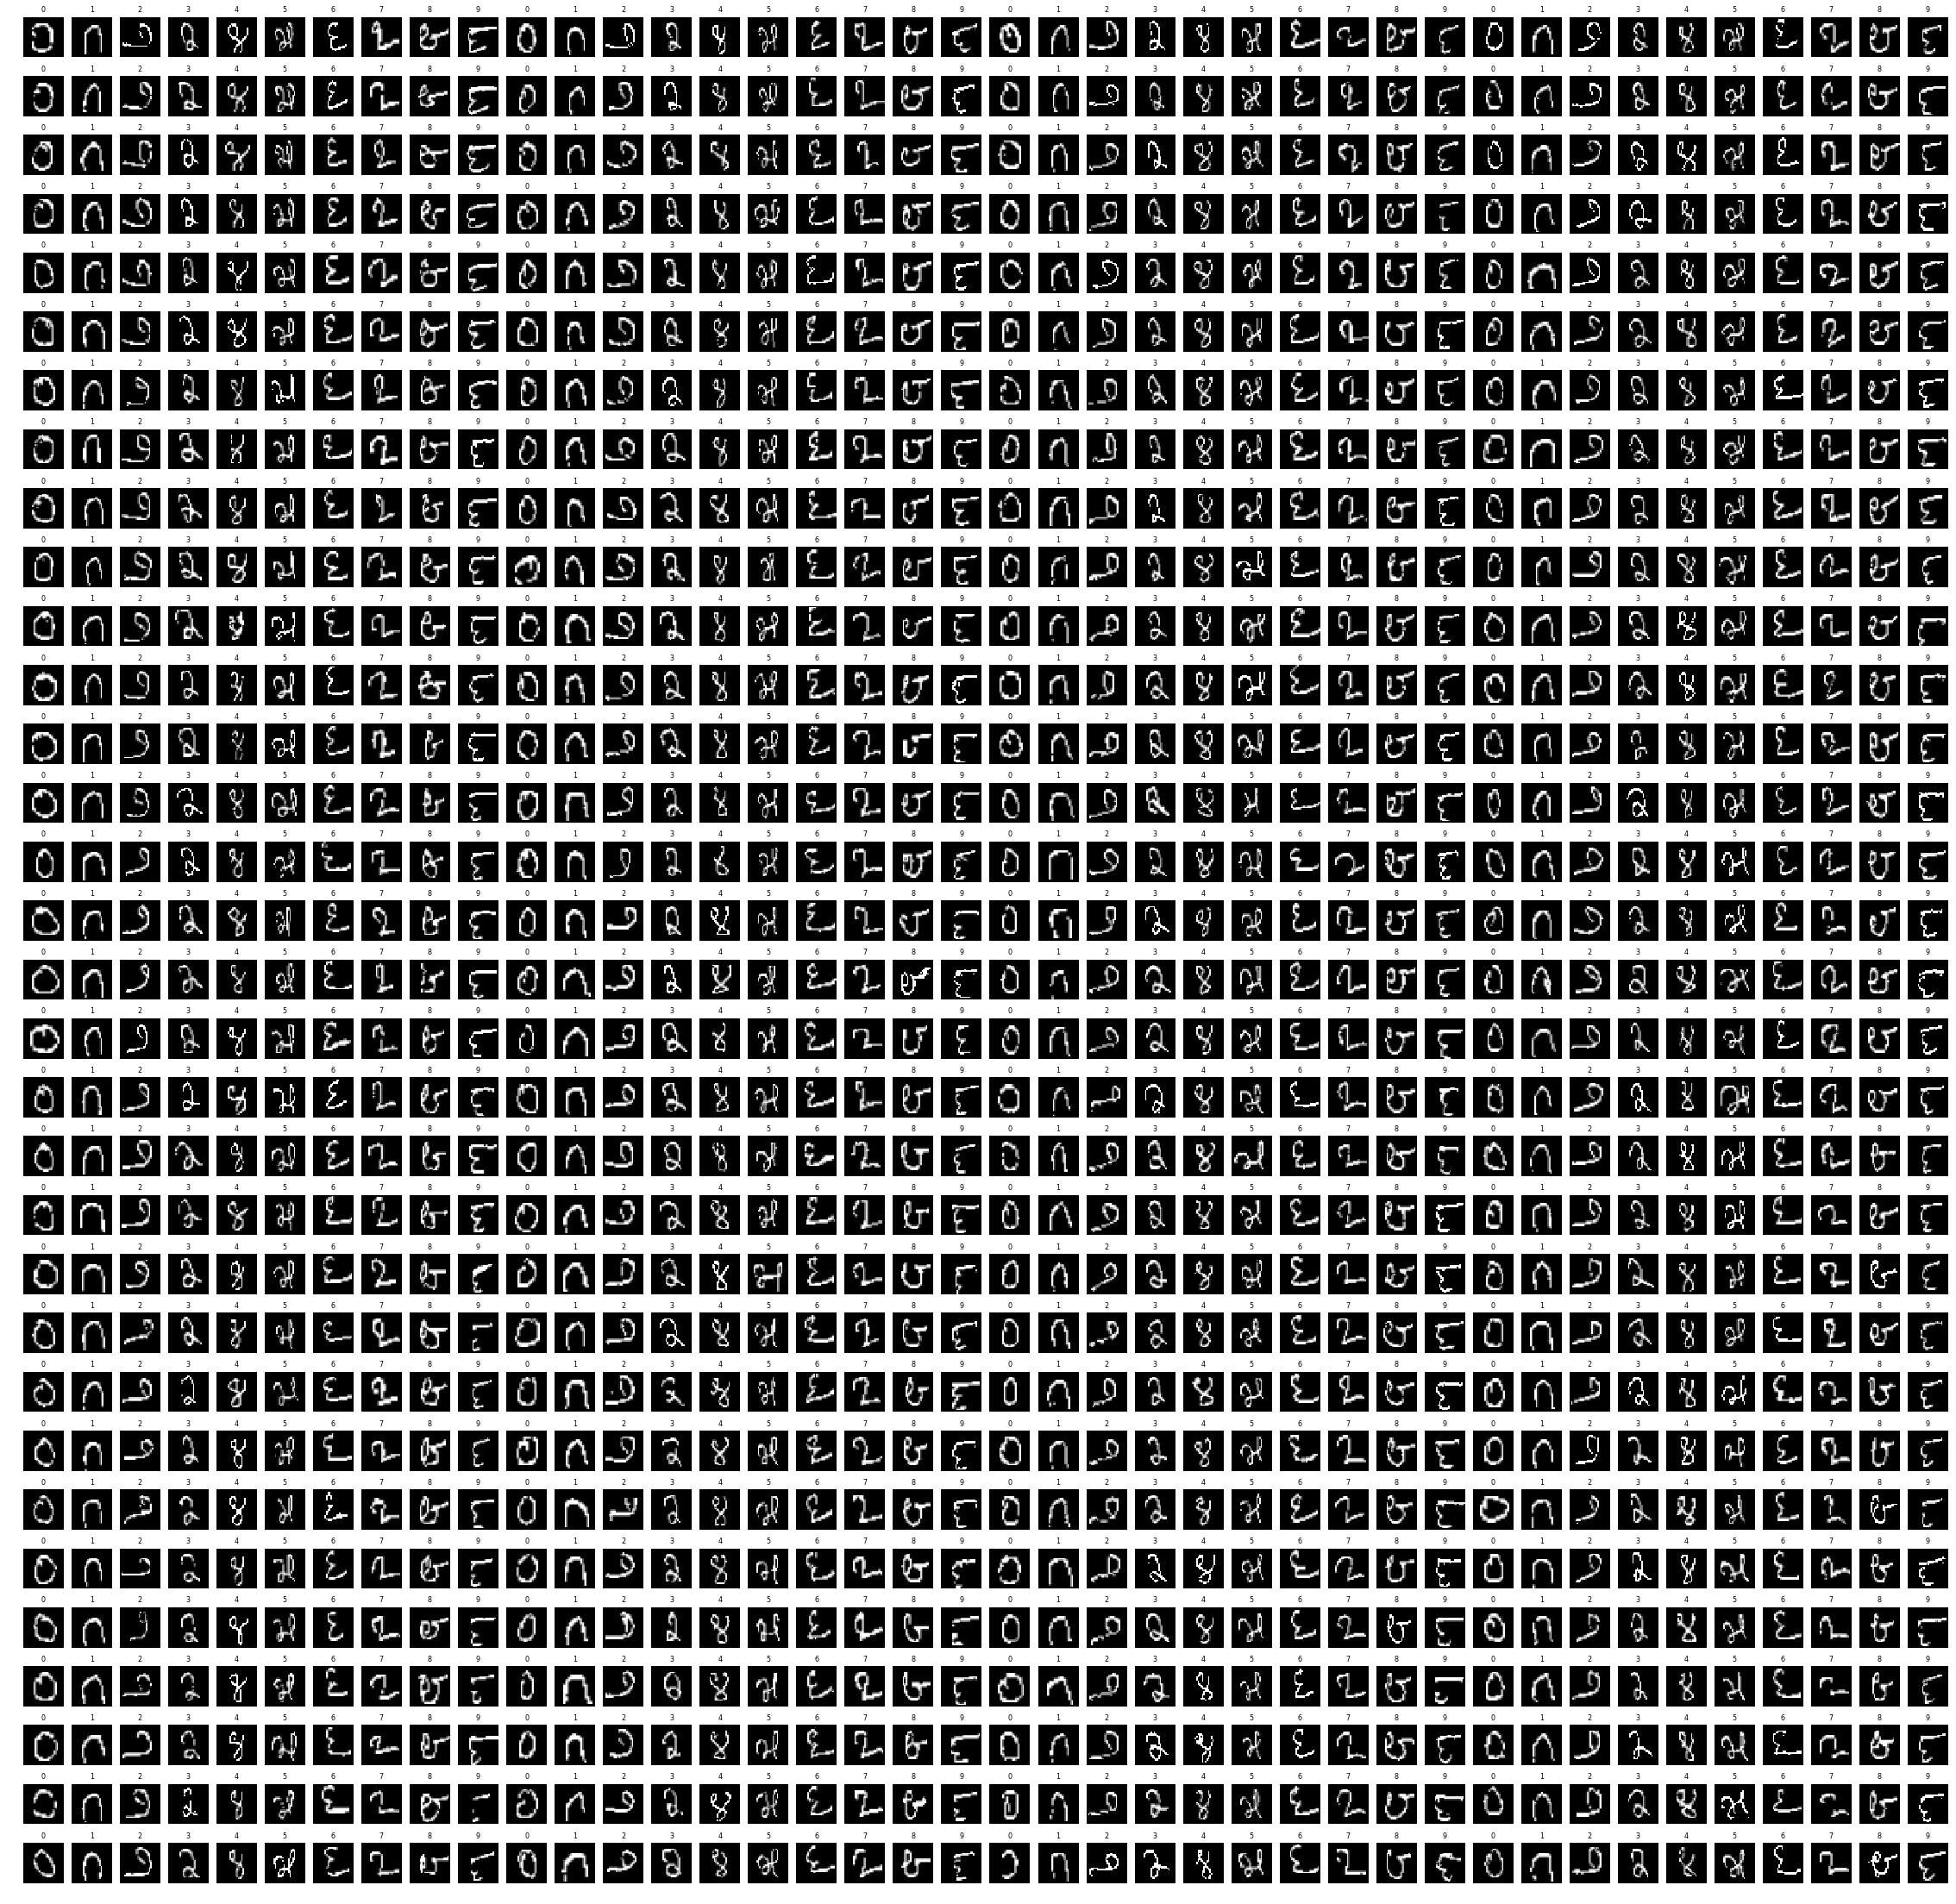

In [10]:
X,y=extract_digits_labels(cropped)
ind=1
plt.figure(figsize=(40,40))
for i in range(32):
  for j in range(40):
      plt.subplot(32,40,ind)
      ind+=1
      plt.imshow(X[i,j,:,:,0],cmap='gray')
      plt.grid(False)
      plt.axis('off')
      plt.title(int(y[i,j]),fontsize=8)

In [11]:
X_scan_0=X.reshape(32*40,28,28,1)
y_scan_0=y.flatten()
print(np.shape(X_scan_0),np.shape(y_scan_0))

(1280, 28, 28, 1) (1280,)


# Post-processing sanity checks:

Sanity check 0: Classwise counts

Text(0.5, 1.0, 'Sanity check-0: classwise counts')

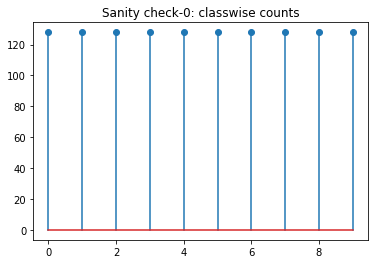

In [12]:
plt.stem(np.bincount(y_scan_0))
plt.title('Sanity check-0: classwise counts')

Sanity check 1: Images of classwise means

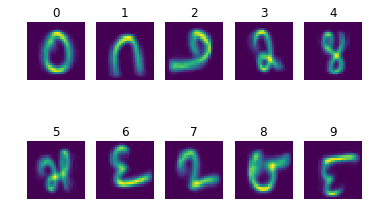

In [13]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.mean(X_scan_0[y_scan_0==i,:,:,0], axis=0))
    plt.axis('off')
    plt.title(i)

 Sanity-check 2: Load MNIST models and test on classes 0, 3 and 7.

In [14]:
from keras.models import load_model
pretrained_model=os.path.join(project_dir,'models/mnist_cnn.h5')
cnn_model = load_model(pretrained_model)
##
x_0=X_scan_0[y_scan_0==0].astype('float32')
x_0/=255
pred_acc_0=(cnn_model.predict_classes(x_0)==0).mean()
##
x_3=X_scan_0[y_scan_0==3].astype('float32')
x_3/=255
pred_acc_3=(cnn_model.predict_classes(x_3)==2).mean()
##
x_7=X_scan_0[y_scan_0==7].astype('float32')
x_7/=255
pred_acc_7=(cnn_model.predict_classes(x_7)==2).mean()
##
print(pred_acc_0,pred_acc_3,pred_acc_7)

Using TensorFlow backend.
W0720 19:53:12.122877 139834950125440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 19:53:12.142525 139834950125440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 19:53:12.172699 139834950125440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0720 19:53:12.175568 139834950125440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 19:53:12.177963 139834

0.953125 0.9609375 0.8359375


Text(0.5, 0.98, 'Misclassified 7s')

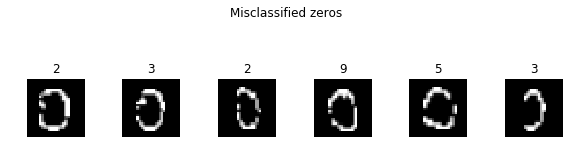

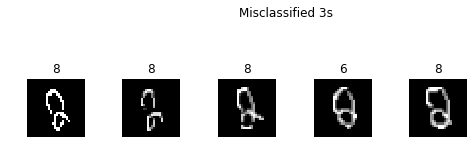

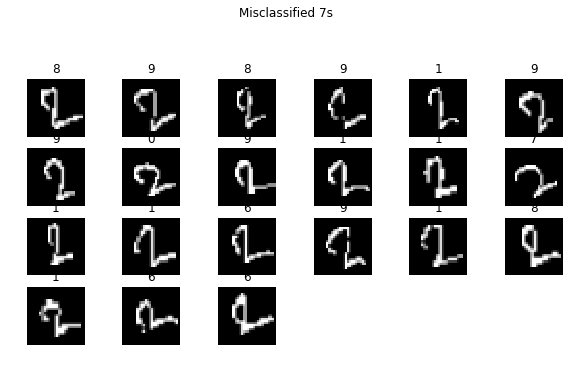

In [20]:
#Let's look at the ones wrongly classified for a specific class
##########################

y_pred_0=cnn_model.predict_classes(x_0)
plt.figure(figsize=(10,10))

for i,ind in enumerate(np.where(y_pred_0!=0)[0]):
  plt.subplot(8,6,i+1)
  plt.imshow(x_0[ind,:,:,0],cmap='gray')
  plt.grid(False)
  plt.axis('off')
  plt.title(y_pred_0[ind])
plt.suptitle('Misclassified zeros')
###########################
y_pred_3=cnn_model.predict_classes(x_3)
plt.figure(figsize=(10,10))

for i,ind in enumerate(np.where(y_pred_3!=2)[0]):
  plt.subplot(8,6,i+1)
  plt.imshow(x_3[ind,:,:,0],cmap='gray')
  plt.grid(False)
  plt.axis('off')
  plt.title(y_pred_3[ind])
plt.suptitle('Misclassified 3s')
##########################
y_pred_7=cnn_model.predict_classes(x_7)
plt.figure(figsize=(10,10))

for i,ind in enumerate(np.where(y_pred_7!=2)[0]):
  plt.subplot(8,6,i+1)
  plt.imshow(x_7[ind,:,:,0],cmap='gray')
  plt.grid(False)
  plt.axis('off')
  plt.title(y_pred_7[ind])
plt.suptitle('Misclassified 7s')  
# plt.tight_layout()